In [1]:
!pip install pydicom

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
import os
import pydicom
import numpy as np

# Función para cargar imágenes y etiquetas de un directorio DICOM
def load_dicom_images_and_labels(directory):
    images = []
    labels = []
    for filename in os.listdir(directory):
        if ".dcm" in filename:
            filepath = os.path.join(directory, filename)
            dicom_file = pydicom.dcmread(filepath)

            # Extraer la imagen
            img_array = dicom_file.pixel_array
            img_array = img_array / np.max(img_array)  # Normalización

            # Extraer la etiqueta del estado del paciente
            if 'PatientState' in dicom_file:
                patient_state = dicom_file.PatientState
                if patient_state == 'Signal absent':
                    label = 0
                else:
                    label = 1
            else:
                # Si no hay información de PatientState, manejar de manera especial
                label = None  # Omitir o asignar un valor por defecto

            images.append(img_array)
            labels.append(label)

    return np.array(images), np.array(labels)

# Carga de datos para múltiples sujetos
data_dir = "/content/drive/MyDrive/RDP"
all_images = []
all_labels = []

for i in range(1, 8):
    subject_dir = os.path.join(data_dir, f"subject_{i}")
    subject_images, subject_labels = load_dicom_images_and_labels(subject_dir)
    all_images.append(subject_images)
    all_labels.append(subject_labels)



ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 1421 and the array at index 6 has size 1130

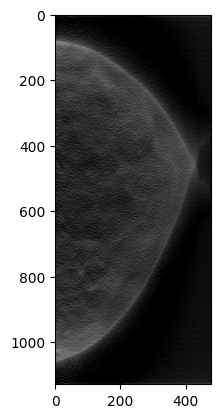

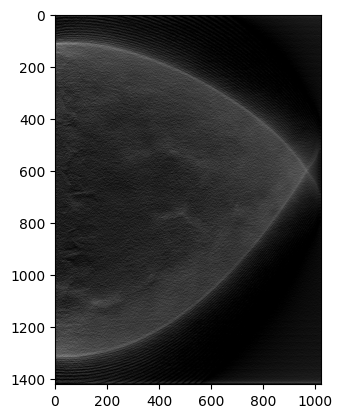

In [13]:
import matplotlib.pyplot as plt
plt.figure()
plt.imshow(all_images[-1][1], cmap="gray")
plt.figure()
plt.imshow(all_images[1][1], cmap="gray")

In [21]:
np.ones((38,1421,1024))

array([[[1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        ...,
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.]],

       [[1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        ...,
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.]],

       [[1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        ...,
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.]],

       ...,

       [[1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        ...,
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1.

In [ ]:
# Convertir listas de listas en un único arreglo numpy para imágenes y etiquetas
all_images = np.concatenate(all_images, axis=0)
all_labels = np.concatenate(all_labels, axis=0)

def decimate_images(images):
    decimated_images = images[:, ::4, ::4]
    return decimated_images

import matplotlib.pyplot as plt
plt.figure()
plt.imshow(all_images[10], cmap="gray")
print("Dimensiones originales:", all_images.shape)
# Aplicar la decimación a todas las imágenes
all_images = decimate_images(all_images)

print("Dimensiones decimadas:", all_images.shape)

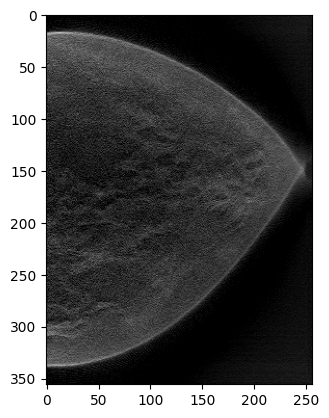

In [2]:
import matplotlib.pyplot as plt

plt.figure()
plt.imshow(all_images[10], cmap="gray")

In [3]:
np.save(data_dir+'decimated_images.npy', all_images)
np.save(data_dir+'labels.npy', all_labels)

In [ ]:
import numpy as np

all_images = np.load("/content/drive/MyDrive/RDP"+'decimated_images.npy')
all_labels = np.load("/content/drive/MyDrive/RDP"+'labels.npy')

In [25]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

# Dividir los datos
X_train, X_test, y_train, y_test = train_test_split(all_images, all_labels, test_size=0.1, random_state=152)

# Construir el modelo CNN
model = Sequential([
    Conv2D(16, (3, 3), activation='relu', input_shape=(X_train.shape[1], X_train.shape[2], 1)),
    MaxPooling2D((2, 2)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')
])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Entrenamiento del modelo
history = model.fit(X_train, y_train, epochs=20, validation_split=0.05, batch_size=32)

# Evaluar el modelo
model.evaluate(X_test, y_test)

Epoch 1/20
14/14 [==============================] - 2s 63ms/step - loss: 0.7158 - accuracy: 0.6636 - val_loss: 0.5096 - val_accuracy: 0.7917
Epoch 2/20
14/14 [==============================] - 1s 40ms/step - loss: 0.5344 - accuracy: 0.7757 - val_loss: 0.5051 - val_accuracy: 0.7917
Epoch 3/20
14/14 [==============================] - 1s 39ms/step - loss: 0.4998 - accuracy: 0.7757 - val_loss: 0.4821 - val_accuracy: 0.7917
Epoch 4/20
14/14 [==============================] - 1s 40ms/step - loss: 0.4423 - accuracy: 0.7849 - val_loss: 0.4465 - val_accuracy: 0.8333
Epoch 5/20
14/14 [==============================] - 0s 35ms/step - loss: 0.3569 - accuracy: 0.8261 - val_loss: 0.3313 - val_accuracy: 0.8333
Epoch 6/20
14/14 [==============================] - 0s 35ms/step - loss: 0.2757 - accuracy: 0.9176 - val_loss: 0.3226 - val_accuracy: 0.7917
Epoch 7/20
14/14 [==============================] - 0s 35ms/step - loss: 0.1407 - accuracy: 0.9657 - val_loss: 0.2004 - val_accuracy: 0.9167
Epoch 8/20
14

[0.02327321097254753, 1.0]

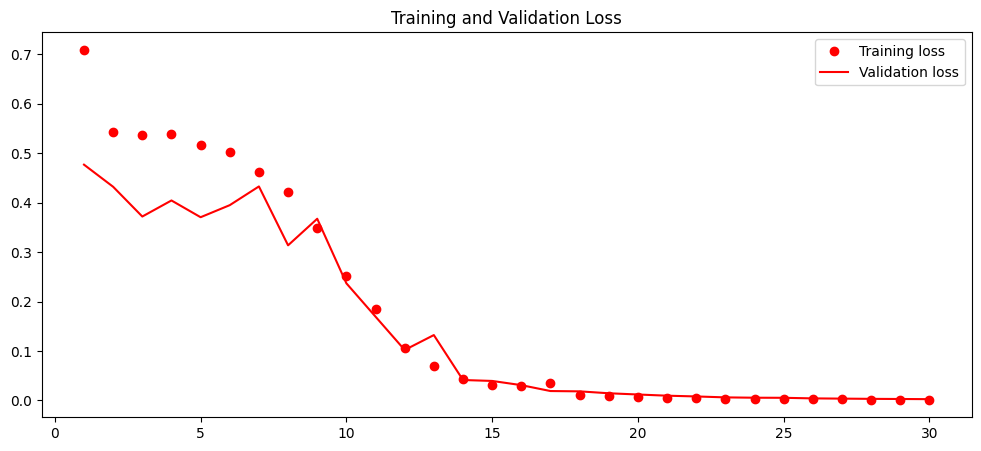

In [22]:
import matplotlib.pyplot as plt
def plot_training_history(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, 20 + 1)
    plt.figure(figsize=(12, 5))
    plt.plot(epochs, loss, 'ro', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

plot_training_history(history)

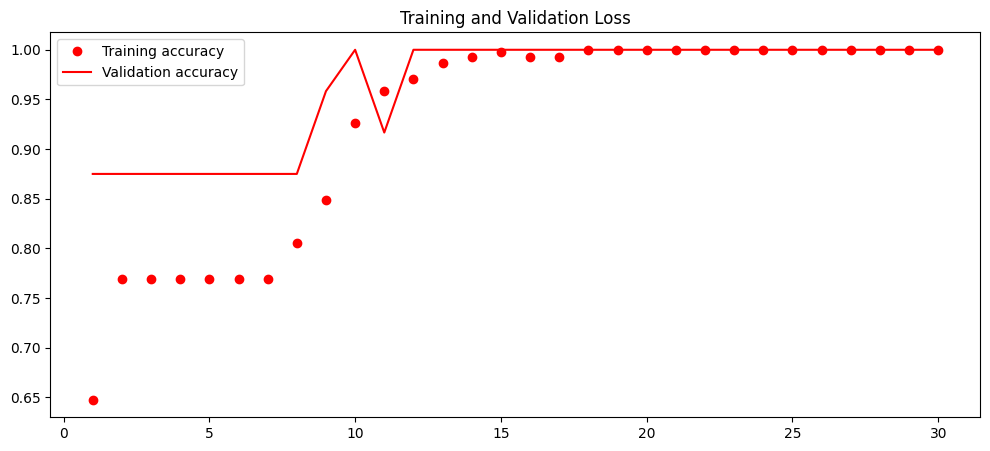

In [23]:
def plot_training_history(history):
    loss = history.history['accuracy']
    val_loss = history.history['val_accuracy']
    epochs = range(1, 20 + 1)
    plt.figure(figsize=(12, 5))
    plt.plot(epochs, loss, 'ro', label='Training accuracy')
    plt.plot(epochs, val_loss, 'r', label='Validation accuracy')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

plot_training_history(history)